In [1]:
import numpy as np
import pandas as pd

## Pandas display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

from tqdm.notebook import tqdm
import re
import nltk
import spacy
import string
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import *
import sklearn.model_selection
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_extraction.text import *
from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

import xgboost as xgb

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

!pip install emot
import emot

import pickle
import logging

import gensim

[nltk_data] Downloading package wordnet to /home/victor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/victor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/victor/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Client support

# 1. Data extraction

In [4]:
brand = "amazon"

In [5]:
filename = "../../data/extraction_twint/tweets_data/data_service_clients/with_user_info/"+brand+".csv"

In [6]:
# All information is in full_df
full_df = pd.read_csv(filename, lineterminator='\n')

# Only the info needed is in df
df = full_df[["tweet","reply_time",'tweets', 'following', 'followers', 'likes']].copy()
df= df.rename(columns={'tweet':'raw'})
df= df.rename(columns={'tweets':'nb_tweets_of_user'})

In [7]:
full_df.columns

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest', 'datetime',
       'reply_time', 'id_user', 'name_user', 'bio', 'location', 'url',
       'join_date', 'join_time', 'tweets', 'following', 'followers', 'likes',
       'media', 'private', 'verified', 'profile_image_url',
       'background_image'],
      dtype='object')

In [8]:
df.columns

Index(['raw', 'reply_time', 'nb_tweets_of_user', 'following', 'followers',
       'likes'],
      dtype='object')

In [9]:
df.head()

,raw,reply_time,nb_tweets_of_user,following,followers,likes
0,Wt a disgusting amazon ! @JeffBezos @AmitAgarwal . You provide a link where we can put up issue . Its very bad experience for us . @ZeeNews @aajtak @ndtv @htTweets,NaN,191,275,19,246
1,A pic up boy come to my house for used product bt he not received. He didn’t know the issue and argument with my wife .,0 days 00:05:40.000000000,191,275,19,246
2,"I m not getting your point. Wt will i do for replacement or money back ?\nSorry i will not purchase anything from amazon next time . #Meresegltihogei , next time kisi se nhi hone du ga# amazon meri bhool#",0 days 00:06:35.000000000,191,275,19,246
3,"I think you don’t have dignity of valuable customers. Wt a network ! You couldn’t accessible my problem & not pass it to concerned support team . Unbelievable torcher , mentaly also wasting of time , money .",0 days 00:03:19.000000000,191,275,19,246
4,I am already shared information on link which is provided by you. And also a mail received from amazon team but nobody pic up came for used product. Pls let me know when will it replace?,0 days 00:42:01.000000000,191,275,19,246


In [10]:
df.shape

(6290, 6)

In [11]:
print("Numbers of tweets without response")
sum(df.reply_time.isnull())

Numbers of tweets without response


1534

In [12]:
#reply time to timedelta
df['reply_time']=df['reply_time'].map(pd.to_timedelta)

#reply time in minutes
df['reply_time']=df['reply_time'].map(lambda x: x.days*1440 + x.seconds//60)

In [13]:
df.dtypes

raw                   object
reply_time           float64
nb_tweets_of_user      int64
following              int64
followers              int64
likes                  int64
dtype: object

In [14]:
df["raw"] = df["raw"].astype('str')

In [15]:
# Samples of answered tweets
df[~np.isnan(df.reply_time)]

,raw,reply_time,nb_tweets_of_user,following,followers,likes
1,A pic up boy come to my house for used product bt he not received. He didn’t know the issue and argument with my wife .,5.0,191,275,19,246
2,"I m not getting your point. Wt will i do for replacement or money back ?\nSorry i will not purchase anything from amazon next time . #Meresegltihogei , next time kisi se nhi hone du ga# amazon meri bhool#",6.0,191,275,19,246
3,"I think you don’t have dignity of valuable customers. Wt a network ! You couldn’t accessible my problem & not pass it to concerned support team . Unbelievable torcher , mentaly also wasting of time , money .",3.0,191,275,19,246
4,I am already shared information on link which is provided by you. And also a mail received from amazon team but nobody pic up came for used product. Pls let me know when will it replace?,42.0,191,275,19,246
5,& pls tell me when amazon pic up old & used shoes from my address? & replacement status?,5.0,191,275,19,246
...,...,...,...,...,...,...
6284,I know Amazon is trying to take over the world but they should really leave shipping to the more reliable @UPS @FedEx and @USPS,8.0,1972,367,44,1518
6285,Amazon shipping I never have issues with @UPS or @FedEx it’s always always Amazon shipping,15.0,1972,367,44,1518
6286,Yes everytime I have to go pick up my packages,4.0,168,23,69,460
6287,"Thanks for your quick reply, i dont. wanna waste my subscription",2.0,9857,1848,425,1078


In [16]:
# Samples of unanswered tweets
df[np.isnan(df.reply_time)]

,raw,reply_time,nb_tweets_of_user,following,followers,likes
0,Wt a disgusting amazon ! @JeffBezos @AmitAgarwal . You provide a link where we can put up issue . Its very bad experience for us . @ZeeNews @aajtak @ndtv @htTweets,NaN,191,275,19,246
14,7866061659 is call for refund your money this is fraud yes no,NaN,56,90,0,4
17,My account is locked mobile no 8882486916,NaN,56,90,0,4
18,It’s from Amazon @AmazonUK,NaN,89,11,1,39
19,Check DM. \nI have sent details.,NaN,4669,65,97,4322
...,...,...,...,...,...,...
6268,"They offered me another $10, which still leaves them short of the products price. How hard is it to just expedite me another stand? I’m literally trying to be such a nice guy here.",NaN,3123,925,216,11427
6274,Lol @AmazonHelp will send you a $5 credit towards your account 😂😂😂,NaN,9325,1450,1498,8550
6276,"I've been told by multiple customer service reps @Amazon that without my billing address, you cannot help me",NaN,764,104,76,145
6277,Full marks for the speedy response - thank you. But I’m really annoyed you’ve ruined my night in. I had to buy the DVD to continue watching. Thank goodness for @Cex who’ll get me the DVD for tomorrow for £8.,NaN,35230,675,268,155


# 2. Pre-processing

### Change text

In [17]:
def remove_uppercase(text):
    return text.lower()
    
def remove_punctuation(text):
    """custom function to remove the punctuation"""  
    PUNCT_TO_REMOVE = string.punctuation
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words('english'))
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_urls(text):
    words=[]
    for w in text.split(" "):
        if not(w.startswith("http") or w.startswith("www") or w.startswith("pic.twitter")):
            words+=[w]
    return ' '.join(words)

def get_frequent_words(column):
    cnt = Counter()
    for text in column.values:
        for word in text.split():
            cnt[word] += 1
    FREQWORDS = set([w for (w, wc) in cnt.most_common(20)])
    #RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]])
    return FREQWORDS

FREQWORDS = get_frequent_words(df.raw)
def remove_frequent_words(text, FREQWORDS):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

def remove_numbers(text):
    return re.sub(r'[0-9\.]+', '', text)

def remove_spaces(text):
    return re.sub(' +', ' ', text)

### Emoticons to words

In [18]:
def convert_emojis(text):
    emo= emot.emoji(text)
    for i in range(len(emo['value'])):
        text = text.replace(emo['value'][i], " "+ emo['mean'][i]).replace(":","")
    return text

text = "game is on 🔥🔥 😭"
print(convert_emojis(text))

game is on  fire fire  loudly_crying_face


### Chat words conversion

In [19]:
words = "../../source/slang.txt"
with open(words, 'r') as file:
    chat_words_str = file.read()

In [20]:
chat_words_map_dict = {}
chat_words_list = []

for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("one minute BRB")

'one minute Be Right Back'

In [21]:
#df.raw.apply(chat_words_conversion)

### Stemming

In [22]:
#not so good results

def stem_words(text):
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in text.split()])

#df["stemmed"] = df["raw"].apply(lambda text: stem_words(text))
#df.head()

### Lemmatization

In [23]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) 
                     for word, pos in pos_tagged_text])
    #return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

ex = "hello I am buying a fruit"
lemmatize_words(ex)
#df["raw_lemmatized"] = df["raw"].apply(lambda text: lemmatize_words(text))
#df.head()

'hello I be buy a fruit'

### Tokenisation

In [24]:
import re

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#df['tweet_tokenized']=df["tweet_lower"].apply(lambda text: tokenize(text))

Final function to do all preprocessing

In [25]:
def preprocess(df):
    df["clean_tweet"] = df["raw"].apply(lambda text: remove_uppercase(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_punctuation(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_stopwords(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: convert_emojis(text))
    #FREQWORDS = get_frequent_words(df.clean_tweet)
    #df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text, FREQWORDS))
    #df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_frequent_words(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_urls(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: chat_words_conversion(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_numbers(text))
    
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: lemmatize_words(text))
    df["clean_tweet"] = df["clean_tweet"].apply(lambda text: remove_spaces(text))
    # Remove small tweets
    df = df[df['clean_tweet'].apply(lambda x: len(x) > 3)]
    #df["clean_tweet_tokenized"] = df["clean_tweet"].apply(lambda text: tokenize(text))
    
    return df

In [26]:
df = preprocess(df)

# 3. Feature engineering & Data analysis

### Reply time 

In [27]:
df['has_reply'] = df['reply_time'].map(lambda x : not(math.isnan(x)))

In [28]:
df['has_reply'].value_counts()

True     4722
False    1526
Name: has_reply, dtype: int64

In [29]:
print ("Pourcentage de tweets répondus")
len(df[df['has_reply']==True])*100/len(df)

Pourcentage de tweets répondus


75.57618437900128

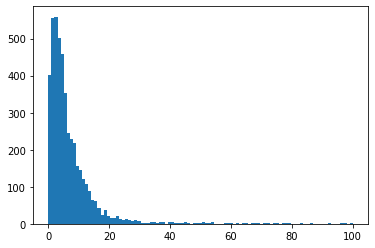

In [30]:
bins=np.linspace(0,100,100)
plt.hist(df['reply_time'],bins)
plt.show()

In [31]:
with pd.option_context('float_format', '{:f}'.format):
    print(df.reply_time.describe())

count   4722.000000
mean      28.329310
std      192.423197
min        0.000000
25%        3.000000
50%        5.000000
75%       10.000000
max     4435.000000
Name: reply_time, dtype: float64


In [32]:
df["reply_time"] = df["reply_time"].astype('float')

In [33]:
with pd.option_context('float_format', '{:f}'.format):
    print(df[df["reply_time"]>0].reply_time.describe())

count   4651.000000
mean      28.761772
std      193.854584
min        1.000000
25%        3.000000
50%        5.000000
75%       10.000000
max     4435.000000
Name: reply_time, dtype: float64


##### Create a target column if we want classification to be more precise 

In [34]:
len(df[df.reply_time<5])

2018

In [35]:
df[df.reply_time<5].head()

,raw,reply_time,nb_tweets_of_user,following,followers,likes,clean_tweet,has_reply
3,"I think you don’t have dignity of valuable customers. Wt a network ! You couldn’t accessible my problem & not pass it to concerned support team . Unbelievable torcher , mentaly also wasting of time , money .",3.0,191,275,19,246,think don’t dignity valuable customer wt network couldn’t accessible problem pas concern support team unbelievable torcher mentaly also waste time money,True
7,Pls find attachment... this is my detail pic.twitter.com/aBpjt1O0cS,2.0,191,275,19,246,Please find attachment detail pictwittercomabpjtocs,True
9,How many time i will share detail ? . I am not a animal who live in jungl.. i have lot of work so you can take my order detail from attachment. Disgusting! @JeffBezos pic.twitter.com/xQV3KQXEt9,1.0,191,275,19,246,many time share detail animal live jungl lot work take order detail attachment disgust jeffbezos pictwittercomxqvkqxet,True
10,It’s disrespectful for us . We are trying to talk amazon team but they directly refused that its your order we can’t help . And why are you expect from us that we will not put this matter on publicly. Wah! @JeffBezos,4.0,191,275,19,246,it’s disrespectful u try talk amazon team directly refuse order can’t help expect u put matter publicly wah jeffbezos,True
11,@AmazonHelp I couldn’t receive my originiazl order as per my order specifications . I have received old shoes as per my order number 407-8606818-4694719. Pls solve my problems on urgent base . Nobody responded from amazon support team and rudely talk to m wfe pic.twitter.com/TCPtsLC3sE,4.0,191,275,19,246,amazonhelp couldn’t receive originiazl order per order specification receive old shoe per order number Please solve problem urgent base nobody respond amazon support team rudely talk wfe pictwittercomtcptslcse,True


In [36]:
# Tweet is urgent if answer in less than 5 minutes
df['objective'] = df['reply_time'].map(lambda x : (x < 8))

In [37]:
df.objective.value_counts()

False    3173
True     3075
Name: objective, dtype: int64

In [38]:
print ("Pourcentage de tweets catégorisés positifs pour l'urgence")
len(df[df['objective']==True])*100/len(df)

Pourcentage de tweets catégorisés positifs pour l'urgence


49.2157490396927

### Tweet length

In [39]:
df['length']=df['raw'].apply(lambda x:len(x)-x.count(" "))

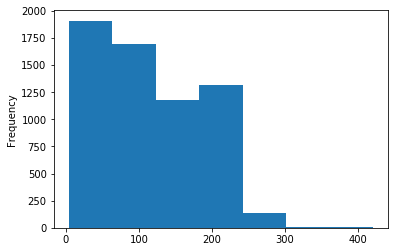

In [40]:
df.length.plot.hist(bins=7)

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


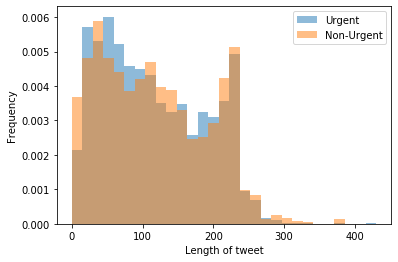

In [41]:
bins=np.linspace(0,430,30)
plt.hist(df[df.has_reply==True]['length'],bins, alpha=0.5, normed=True, label='Urgent')
plt.hist(df[df.has_reply==False]['length'],bins, alpha=0.5, normed=True, label='Non-Urgent')
plt.legend(loc='upper right')
plt.xlabel("Length of tweet")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 1.0, 'Distribution of urgent tweets (True) and non-urgent (False) according to tweet length')

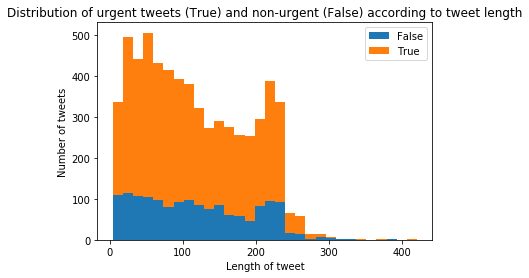

In [42]:
replies = df.has_reply.unique()
plt.hist([df.loc[df.has_reply == x, 'length'] for x in replies], label=replies, stacked=True, bins=30)
plt.legend(loc='upper right')
plt.xlabel("Length of tweet")
plt.ylabel("Number of tweets")
plt.title("Distribution of urgent tweets (True) and non-urgent (False) according to tweet length")

In [43]:
df.length.describe()

count    6248.000000
mean      116.230314
std        72.447957
min         4.000000
25%        54.000000
50%       106.000000
75%       178.000000
max       421.000000
Name: length, dtype: float64

### Uppercase percentage

In [44]:
def count_upper(text):
    count = sum([1 for char in text if char.isupper()])
    return round(count/(len(text)-text.count(" ")),3)*100

df['upper']=df['raw'].apply(count_upper)

Text(0.5, 1.0, 'Distribution of urgent tweets (True) and non-urgent (False) according to upper character density')

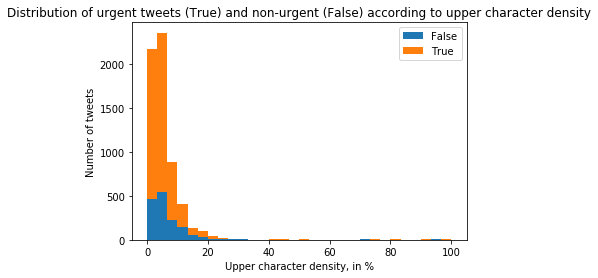

In [45]:
replies = df.has_reply.unique()
plt.hist([df.loc[df.has_reply == x, 'upper'] for x in replies], label=replies, stacked=True, bins=30)
plt.legend(loc='upper right')
plt.xlabel("Upper character density, in %")
plt.ylabel("Number of tweets")
plt.title("Distribution of urgent tweets (True) and non-urgent (False) according to upper character density")

### Punctuation percentage

In [46]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text)-text.count(" ")),3)*100

df['punct']=df['raw'].apply(count_punct)

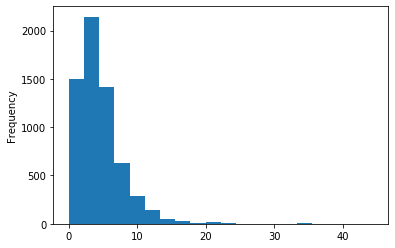

In [47]:
df.punct.plot.hist(bins=20)

/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/home/victor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


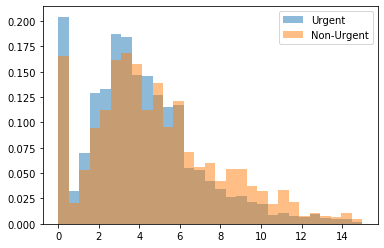

In [48]:
bins=np.linspace(0,15,30)
plt.hist(df[df.has_reply==True]['punct'],bins, alpha=0.5, normed=True, label='Urgent')
plt.hist(df[df.has_reply==False]['punct'],bins, alpha=0.5, normed=True, label='Non-Urgent')
plt.legend(loc='upper right')
plt.show()

In [49]:
df.punct.describe()

count    6248.000000
mean        4.506466
std         3.549013
min         0.000000
25%         2.300000
50%         3.900000
75%         5.900000
max        44.400000
Name: punct, dtype: float64

Text(0.5, 1.0, 'Distribution of urgent tweets (True) and non-urgent (False) according to punctuation density')

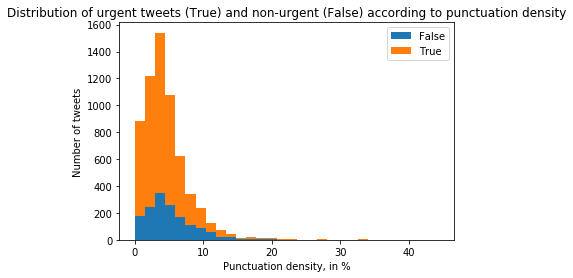

In [50]:
replies = df.has_reply.unique()
plt.hist([df.loc[df.has_reply == x, 'punct'] for x in replies], label=replies, stacked=True, bins=30)
plt.legend(loc='upper right')
plt.xlabel("Punctuation density, in %")
plt.ylabel("Number of tweets")
plt.title("Distribution of urgent tweets (True) and non-urgent (False) according to punctuation density")

### Direct mention of brand in tweet

In [51]:
brand_account = "@AmazonHelp"

In [52]:
df["direct_mention"] = df["raw"].apply(lambda x: brand_account in x)

In [53]:
df.direct_mention.value_counts()

False    4587
True     1661
Name: direct_mention, dtype: int64

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'Distribution of urgent tweets (True) and non-urgent (False) according to direct_mention')

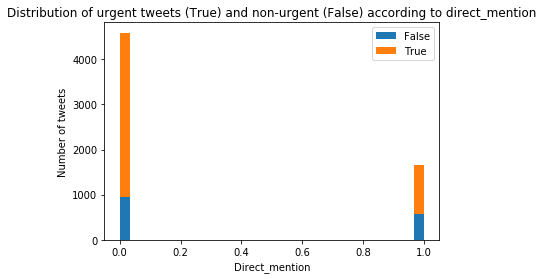

In [54]:
replies = df.has_reply.unique()
plt.hist([df.loc[df.has_reply == x, 'direct_mention'] for x in replies], label=replies, stacked=True, bins=30)
plt.legend(loc='upper right')
plt.xlabel("Direct_mention")
plt.ylabel("Number of tweets")
plt.title("Distribution of urgent tweets (True) and non-urgent (False) according to direct_mention")

In [55]:
len(df[(df['direct_mention']==True)&(df['has_reply']==True)])*100/len(df[df['direct_mention']==True])

65.92414208308249

In [56]:
len(df[(df['direct_mention']==True)&(df['has_reply']==False)])*100/len(df[df['direct_mention']==True])

34.07585791691752

In [57]:
len(df[(df['direct_mention']==False)&(df['has_reply']==True)])*100/len(df[df['direct_mention']==False])

79.07128842380641

In [58]:
len(df[(df['direct_mention']==False)&(df['has_reply']==False)])*100/len(df[df['direct_mention']==False])

20.928711576193592

Text(0.5, 1.0, 'Distribution of tweets containing a direct mention')

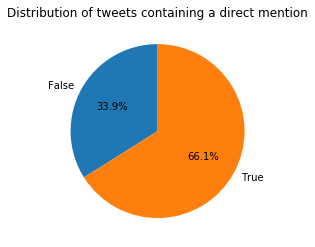

In [59]:
values = [33.9, 66]
plt.pie(values, labels=df.has_reply.unique(), autopct='%1.1f%%', startangle=90)
plt.title("Distribution of tweets containing a direct mention")

Text(0.5, 1.0, 'Distribution of tweets not containing a direct mention')

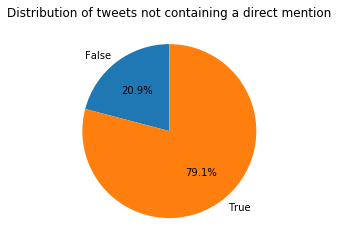

In [60]:
values = [20.9, 79.1]
plt.pie(values, labels=df.has_reply.unique(), autopct='%1.1f%%', startangle=90)
plt.title("Distribution of tweets not containing a direct mention")

### Sentiment analysis of tweet

In [61]:
##SENTIMENT ANALYSIS

text = "Literally about to cancel Amazon Prime. Pretty much the only reason being the removal of Seinfeld! Sorry @primevideouk @AmazonHelp"
text = "I love that"

opinion = TextBlob(text, analyzer=NaiveBayesAnalyzer())
opinion.sentiment
opinion.sentiment.classification == 'pos'

True

In [62]:
tqdm.pandas()
analyzer=NaiveBayesAnalyzer()
df["positive_sentiment"] = df["raw"].progress_apply(lambda x:  TextBlob(x, analyzer=analyzer).sentiment.classification == 'pos')

/home/victor/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Text(0.5, 1.0, 'Distribution of urgent tweets (True) and non-urgent (False) according to sentiment')

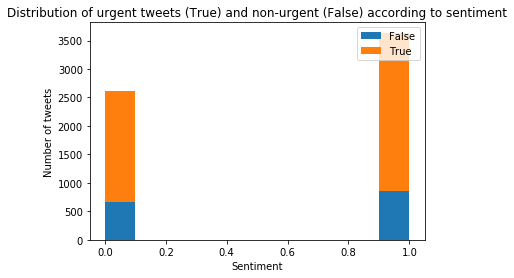

In [63]:
replies = df.has_reply.unique()
plt.hist([df.loc[df.has_reply == x, 'positive_sentiment'] for x in replies], label=replies, stacked=True)
plt.legend(loc='upper right')
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Distribution of urgent tweets (True) and non-urgent (False) according to sentiment")

In [64]:
df.positive_sentiment.value_counts()

True     3638
False    2610
Name: positive_sentiment, dtype: int64

### Upsampling / Downsampling 

In [65]:
def downsampling(X_train, y_train):

    print(X_train.shape)
    print(y_train.shape)
    
    count_class_true, count_class_false = y_train.value_counts()
    print("Before downsampling True / False")
    print(count_class_true, count_class_false)
    
    count_class = min(count_class_true, count_class_false)
    
    true_index = np.where(y_train==True)[0].tolist()
    false_index = np.where(y_train==False)[0].tolist()
    
    # Divide by class
    X_class_true = X_train[X_train.index.isin(true_index)]
    X_class_false = X_train[X_train.index.isin(false_index)]


    X_class_false_under = X_class_false.sample(count_class, replace=True)
    X_class_true_under = X_class_true.sample(count_class,replace=True)
    
    X_df = pd.concat([X_class_false_under, X_class_true_under], axis=0)
    y_df = y_train[y_train.index.isin(X_df.index)]


    count_class_true, count_class_false = y_df.value_counts()
    print("After downsampling True / False")
    print(count_class_true, count_class_false)
    
    return X_df, y_df

# 4. Models

# 4A. Final pre-processing

In [66]:
df = preprocess(df)

In [67]:
len(df)

6248

In [68]:
#get_frequent_words(df.clean_tweet)

# 4B. Vectorization

###  1. Bag Of Words

In [69]:
def bow_encode(text):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(text)
    print("Vocab size is: ", len(vectorizer.get_feature_names()))
    return X

In [70]:
np.unique(bow_encode(df.clean_tweet).toarray())

Vocab size is:  8411


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

#### Visualize Bag Of Words

Vocab size is:  8411


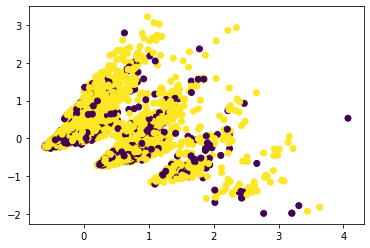

In [71]:
X = bow_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1], c=df.has_reply)

### 2. Tf IdF 

In [72]:
def tfidf_encode(text):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
    return tfidf_vectorizer.fit_transform(text)

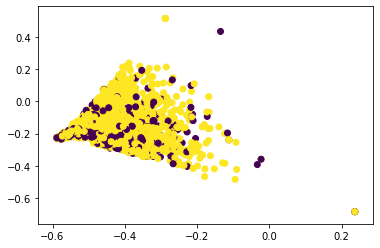

In [73]:
Z = tfidf_encode(df.clean_tweet).todense()
pca = PCA(n_components=2).fit(X)
Z_data2D = pca.transform(Z)
plt.scatter(Z_data2D[:,0], Z_data2D[:,1], c=df.has_reply)

### 3. Word2vec

In this section, we load a pre-trained model (GloVe or Google Word2Vec), and generate and store the embeddings of all the tweets. Caution : the model needs to be downloaded before

#### Google Word2Vec loading

In [ ]:
model_path = "../../source/embeddings/GoogleVectors300d/GoogleNews-vectors-negative300.bin"
binary = True
storage_folder = "../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GoogleVectors300d/"

#### GloVe loading

In [ ]:
model_path = "../../source/embeddings/GloveTwitter200d/glove.twitter.27B.200d.txt"
binary = False
storage_folder = "../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GloveTwitter200d/"

#### Create embeddings and save to CSV

In [ ]:
text_features = pd.DataFrame() # creating empty final dataframe
stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(df.clean_tweet): # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc.split(' '): # looping through each word of a single document and spliting through space
        if word not in stopwords: # if word is not present in stopwords then (try)
            try:
                word_vec = embeddings[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    text_features = text_features.append(doc_vector, ignore_index = True) # append each document value to the final dataframe

text_features.to_csv(storage_folder+brand+".csv",)
text_features.head()

### Load embeddings

#### Load from csv

In [ ]:
text_features = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/embeddings/"+brand+".csv", index_col=0)
text_features.head()

### Final function to vectorize (build text features)

In [74]:
def build_text_features(df, y, vect_type, with_downsampling):
    
    logging.info("Extracting features and creating vocabulary...")

    new_df = df[['nb_tweets_of_user', 'following', 'followers', 'likes','direct_mention', 'punct', 'length', 'positive_sentiment', 'clean_tweet']]
    for col in new_df.columns:
        if col != "clean_tweet":
            new_df[col]=new_df[col].apply(lambda x: 0 if np.isnan(x) else int(x))
        
    if "word2vec" in vect_type:
        if "google" in vect_type:
            text_features = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GoogleVectors300d/"+brand+".csv", index_col=0)
        
        if "glove" in vect_type:
            text_features = pd.read_csv("../../data/extraction_twint/tweets_data/data_service_clients/embeddings/GloveTwitter200d/"+brand+".csv", index_col=0)
        
        # Remove nan values in text features
        for col in text_features.columns:
            text_features[col]=text_features[col].apply(lambda x: 0 if np.isnan(x) else x)
        
        new_df.drop(columns="clean_tweet", inplace=True)
        X = pd.merge(text_features, new_df, left_index=True, right_index=True)

        y = df.has_reply
        X_train, X_test, y_train, y_test = train_test_split(new_df,y,train_size=0.80,random_state=44)

        if with_downsampling:
            X_train, y_train = downsampling(X_train, y_train)
        
        vocabulary = []
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(new_df,y,train_size=0.80,random_state=44)

        if with_downsampling:
            X_train, y_train = downsampling(X_train, y_train)

        field = 'clean_tweet'
   
        if 'count' in vect_type:
            vectorizer= CountVectorizer(binary=False, max_df=0.95)
        
        elif "binary" in vect_type:
            vectorizer= CountVectorizer(binary=True, max_df=0.95)

        elif 'tfidf' in vect_type:
            vectorizer=TfidfVectorizer(max_features = 1000, use_idf=True, max_df=0.95)
        #add n-gram
        
        else:
            raise ValueError('Mode should be either count or tfidf')    
       
        # Fit on training data
        vectorizer.fit_transform(X_train[field].values)
        
        vocabulary = vectorizer.get_feature_names()
        
        train_text_features=vectorizer.transform(X_train[field].values).toarray()
        test_text_features=vectorizer.transform(X_test[field].values).toarray()
        
#         for col in text_features.columns:
#             text_features[col]=text_features[col].apply(lambda x: 0 if np.isnan(x) else x)
    
        X_train.drop(columns=['clean_tweet'], inplace=True)
        X_test.drop(columns=['clean_tweet'], inplace=True)

        X_train=np.concatenate((X_train,train_text_features),axis=1)
        X_test=np.concatenate((X_test,test_text_features),axis=1)
    
    return vocabulary, X_train, X_test, y_train, y_test   

# 4C. Model evaluation

### All scores

In [75]:
## PRINT SCORES

def print_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_val = f1_score(y_test, y_pred)
    precision_score_val = precision_score(y_test, y_pred)
    recall_score_val = recall_score(y_test, y_pred)


    string = "RESULTATS \n \
    Accuracy  : {accuracy}% \n \
    F1 score  : {f1_score}\n \
    Precision : {precision}% (how many selected items are relevant)\n \
    Recall    : {recall}% (how many relevant items are selected)\n \
    \n\n\
    STATISTICS\n\
     Proportion of positives in test set    : {positives}%\n\
     Proportion of positives in predictions : {predicted_positives}%\
    "

    print(string.format(accuracy = round(100*accuracy,2),
                        f1_score = round(f1_score_val,4), 
                        precision = round(100*precision_score_val,2), 
                        recall = round(100*recall_score_val,2),
                        positives = round(100*y_test.sum()/len(y_test),2),
                        predicted_positives = round(100*y_pred.sum()/len(y_pred),2),
                       ))

### ROC Curve & AUC 

In [76]:
## DISPLAY ROC CURVE
def display_roc_curve(y_test, X_test, model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_score = round(auc(fpr, tpr),2)

    plt.plot(fpr, tpr, color='darkorange',
             lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC : {}".format(auc_score))

### Confusion matrix 

In [77]:
# CONFUSION MATRIX
def get_confusion_matrix(X_test, y_test, model):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)


### Feature importance 

In [78]:
def importance_plotting(model):
    features2 = pd.DataFrame()
    features2['importance'] = model.feature_importances_
    features2.sort_values(by=['importance'], ascending=False, inplace=True)
    features2 = features2.head(20)
    features2["order"]=features2['importance'].index
    features2["words"] = features2.order.apply(lambda x: vocab[x])
    from sklearn import metrics
    #features2.plot(features2.words, kind='barh', figsize=(10, 8))
    plt.plot(features2.importance, features2.words)
    plt.title('Most important features')
    plt.show()

# 5. Choose, train & test model

In [79]:
def try_model(model, encode_type, df, clf=None, with_downsampling = False):
        
    print("Building the features...")
    y = df.has_reply
    #y = df.objective
    vocab, X_train,X_test,y_train, y_test = build_text_features(df,y, encode_type,with_downsampling)
    
    print("Training the model...")
    if clf:
        clf.fit(X_train,y_train)
        model = clf.best_estimator_
    else:
        model = model.fit(X_train,y_train)
    
    
    print("Making predictions...")
    y_preds = model.predict(X_test)
    
    print("Printing scores...")
    print(classification_report(y_test, y_preds))
    print_scores(y_test,y_preds)
    display_roc_curve(y_test,X_test, model)
    get_confusion_matrix(X_test, y_test, model)
    
    return vocab, model, y_test, y_preds

## Pipeline

In [ ]:
df = preprocess(df)

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_features':[0.2, 0.5,0.7, 0.9]}

#model = LogisticRegression()
#model = MultinomialNB()
#model = RandomForestClassifier(n_estimators=300, max_depth=200)
model = RandomForestClassifier(n_estimators=200, verbose=1, n_jobs=4, class_weight={False: 0.9, True: 0.1})
#model =xgb.XGBClassifier()
#model =xgb.XGBClassifier(random_state=42,learning_rate=0.01)
#model = LinearSVC()

#encode_type = "count"
#encode_type = "tfidf"
encode_type = "binary"
#encode_type = "word2vec_glove"
#encode_type = "word2vec_google"

clf = GridSearchCV(model, parameters)


In [ ]:
vocab, model, y_test, y_preds = try_model(model, encode_type, df)

In [ ]:
importance_plotting(model)

In [ ]:
# Grid Search results
clf.best_params_
pd.DataFrame.from_dict(clf.cv_results_)

In [ ]:
vocab

In [ ]:
model

## Samples 

In [ ]:
#SAMPLES DE TOUTES LES CATEGORIES

##on recupere les tweets urgents manqués

#urgents and not urgents tweets index
positives = y_test[y_test==True].index
negatives = y_test[y_test==False].index

#correct and incorrect predictions index
is_prediction_correct = y_test==y_preds
correct_predictions   = is_prediction_correct[is_prediction_correct==True].index
incorrect_predictions = is_prediction_correct[is_prediction_correct==False].index

#true/false positive/negative index
true_positive_index  = correct_predictions.intersection(positives)
true_negative_index  = correct_predictions.intersection(negatives)
false_positive_index = incorrect_predictions.intersection(negatives)
false_negative_index = incorrect_predictions.intersection(positives)

In [ ]:
df.loc[true_positive_index][['raw']]

In [ ]:
df.loc[true_negative_index][['raw']]

In [ ]:
df.loc[false_positive_index][['raw']]

In [ ]:
df.loc[false_negative_index][['raw']]

# 6. Save Model